In [4]:
import pickle
import numpy as np
import os
import torch
import torch.nn as nn
import re
import sys
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator
import matplotlib.pyplot as plt

root = os.path.dirname(os.path.abspath(os.curdir))
sys.path.append(root)

from sr_model.models.models import AnalyticSR, STDP_SR
from datasets import inputs
import configs

device = 'cpu'

In [63]:
def run_and_plot(exp_dir_or_net, num_steps=2000):
    """
    Plots example M matrices for unbiased and forward-biased 1D walks.
    """
    
    num_states = 25

    # Test datasets
    dset = inputs.Sim1DWalk(num_steps=num_steps, num_states=num_states, left_right_stay_prob=[5,1,1])

    # Load model
    if type(exp_dir_or_net) is str:
        exp_dir = exp_dir_or_net
        with open(exp_dir + 'net_configs.p', 'rb') as f:
            net_configs = pickle.load(f)
        net_configs['num_states'] = num_states
        net = STDP_SR(**net_configs)
        state_dict = torch.load(exp_dir + 'model.pt')
        print(state_dict)
        net.load_state_dict(state_dict)
        net.set_num_states(num_states)
        print(net_configs)
    else:
        net = exp_dir_or_net
    

    dg_inputs = torch.from_numpy(dset.dg_inputs.T).float().to(device).unsqueeze(1)
    with torch.no_grad():
        _, outputs = net(dg_inputs, reset=True)
        outputs = outputs.numpy()
    rnn_M = net.get_M()
    try:
        rnn_M = rnn_M.numpy()
    except:
        pass
    plt.figure()
    plt.imshow(rnn_M)
    plt.xticks([])
    plt.yticks([])
    plt.colorbar()
    plt.show()
        
    # Plot example activity
    from matplotlib.colors import LogNorm
    plt.figure(figsize=(9,3))
    plt.imshow(outputs[:200].T, aspect='auto')
    plt.colorbar()
    plt.show()
    
    # Plot example activity
    from matplotlib.colors import LogNorm
    plt.figure(figsize=(9,3))
    norm_outputs = outputs/(np.max(np.abs(outputs),axis=0)[np.newaxis,:])
    plt.imshow(norm_outputs[:200].T, aspect='auto')
    plt.colorbar()
    plt.show()
    
    # Plot example activity
    plt.figure()
    plt.plot(np.mean(outputs, axis=1))
    plt.show()
        
    # Plot true matrices
    est_T = dset.est_T
    est_M = np.linalg.pinv(
        np.eye(est_T.shape[0]) - net.gamma*est_T
        )
    plt.figure()
    plt.imshow(est_M)
    plt.xticks([])
    plt.yticks([])
    plt.colorbar()
    plt.show()

    return np.mean(np.abs(rnn_M - est_M))

# Linear Network

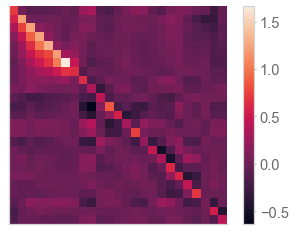

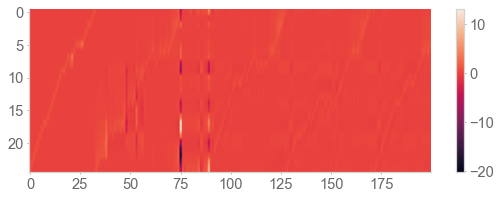

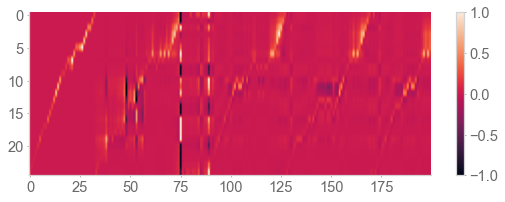

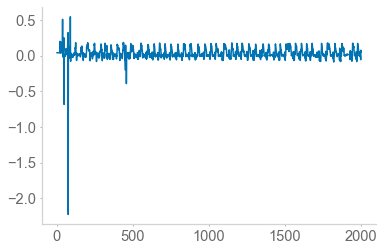

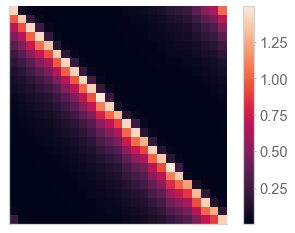

0.19876333328714108

In [64]:
net = STDP_SR(25, 0.8)
run_and_plot(net)

# Truncated Rollout

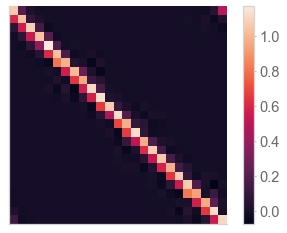

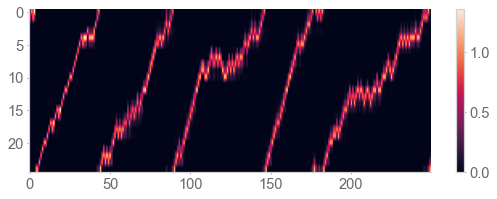

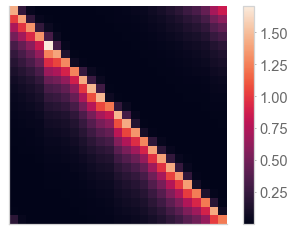

0.1294218074900993

In [16]:
net = STDP_SR(25, 0.8, ca3_kwargs={
    'output_params':{'num_iterations': 2}
        })
run_and_plot(net, num_steps=1000)

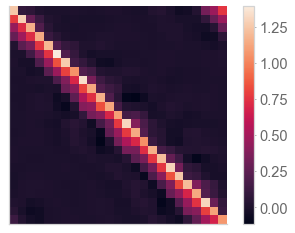

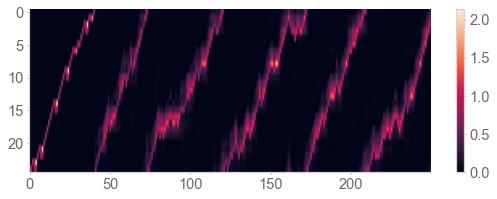

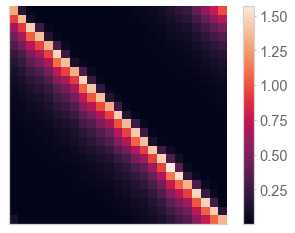

0.09433270944507859

In [17]:
net = STDP_SR(25, 0.8, ca3_kwargs={
    'output_params':{'num_iterations': 4}
        })
run_and_plot(net, num_steps=1000)

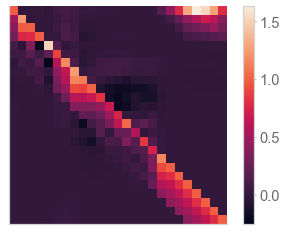

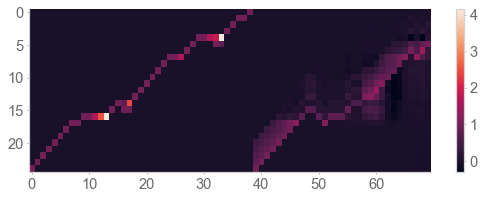

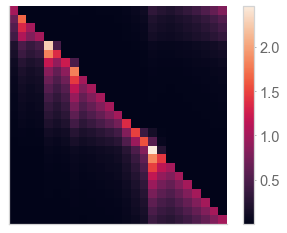

0.11191494820834723

In [30]:
net = STDP_SR(25, 0.8, ca3_kwargs={
    'output_params':{'num_iterations': 5}
        })
run_and_plot(net, num_steps=70)

# Tanh Nonlinearity

/Users/chingfang/opt/anaconda3/envs/aronov/lib/python3.9/site-packages/torch/nn/functional.py:1795: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


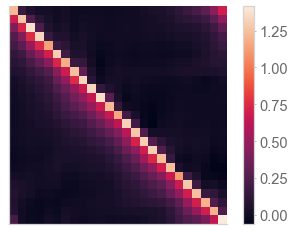

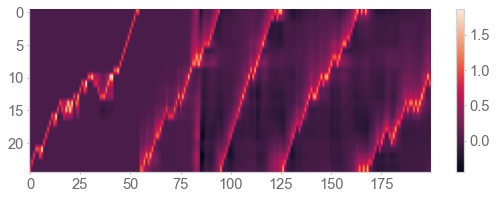

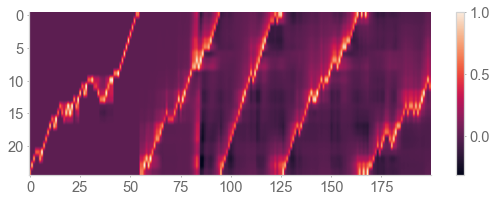

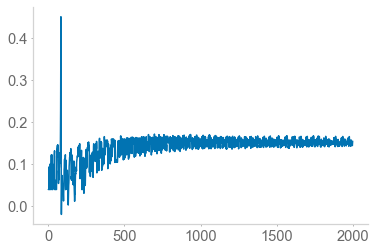

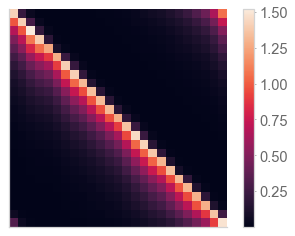

0.060244316518313884

In [60]:
net = STDP_SR(25, 0.8, ca3_kwargs={
'output_params':{'num_iterations': 51,'nonlinearity': 'tanh',
                 'nonlinearity_args': 1.}
    })
run_and_plot(net)